In [1]:
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")

     |████████████████████████████████| 6.4 MB 37.4 MB/s 
     |████████████████████████████████| 49 kB 1.8 MB/s 
     |████████████████████████████████| 130 kB 4.9 MB/s 
     |████████████████████████████████| 145 kB 32.3 MB/s 
     |████████████████████████████████| 74 kB 3.1 MB/s 
     |████████████████████████████████| 747 kB 39.9 MB/s 
     |████████████████████████████████| 743 kB 40.4 MB/s 
     |████████████████████████████████| 636 kB 45.0 MB/s 
     |████████████████████████████████| 112 kB 49.3 MB/s 


In [2]:
!pip install -qq git+https://github.com/cocodataset/panopticapi.git

In [3]:
import torch
import torchvision.transforms as T
import os
from PIL import Image
import cv2
import numpy as np
import math

import itertools
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from panopticapi.utils import rgb2id, id2rgb
import glob
from pathlib import Path

In [4]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
!git clone https://github.com/abdksyed/DETR.git

Cloning into 'DETR'...
remote: Enumerating objects: 29769, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 29769 (delta 13), reused 18 (delta 9), pack-reused 29733
Receiving objects: 100% (29769/29769), 745.57 MiB | 23.00 MiB/s, done.
Resolving deltas: 100% (1208/1208), done.
Checking out files: 100% (43131/43131), done.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!mkdir /content/output
!cp -r /content/drive/MyDrive/Dataset/Checkpoints/122/detect_122_checkpoint.pth /content/output

In [9]:
!cp -r /content/drive/MyDrive/Dataset/Checkpoints/construction_panoptic/19/checkpoint.pth /content/output

In [10]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "DETR/detr/"))
model, postprocessor = torch.hub.load('DETR/detr', 'detr_resnet50_panoptic', source='local', pretrained='/content/output/checkpoint.pth', return_postprocessor=True, num_classes=64)
model
model.eval()
print('Loaded!')

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Loaded!


In [11]:
from copy import deepcopy

In [12]:
MetadataCatalog.clear()

In [13]:
custom_meta = MetadataCatalog.get("construction_panoptic")

In [14]:
custom_meta.set(evaluator_type = 'coco_panoptic_seg', ignore_label = 255, 
                image_root = 'detr/datasets/images', json_file = 'detr/datasets/combined.json',
                name = 'construction_panoptic', panoptic_json = 'detr/datasets/combined.json', 
                panoptic_root = 'detr/datasets')

Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='detr/datasets/images', json_file='detr/datasets/combined.json', name='construction_panoptic', panoptic_json='detr/datasets/combined.json', panoptic_root='detr/datasets')

In [15]:
STUFF_COLOR = [
 [82, 18, 128],
 [255, 255, 128],
 [147, 211, 203],
 [150, 100, 100],
 [168, 171, 172],
 [241, 129, 0],
 [92, 136, 89],
 [218, 88, 184],
 [146, 112, 198],
 [217, 17, 255],
 [124, 74, 181],
 [70, 70, 70],
 [255, 228, 255],
 [154, 208, 0],
 [193, 0, 92],
 [210, 170, 100]
]

THINGS_COLOR = [
 [220, 20, 60],
 [119, 11, 32],
 [0, 0, 142],
 [0, 0, 230],
 [106, 0, 228],
 [0, 60, 100],
 [0, 80, 100],
 [0, 0, 70],
 [0, 0, 192],
 [250, 170, 30],
 [100, 170, 30],
 [220, 220, 0],
 [175, 116, 175],
 [250, 0, 30],
 [165, 42, 42],
 [255, 77, 255],
 [182, 182, 255],
 [0, 226, 252],
 [0, 82, 0],
 [120, 166, 157],
 [110, 76, 0],
 [174, 57, 255],
 [199, 100, 0],
 [72, 0, 118],
 [255, 179, 240],
 [0, 125, 92],
 [209, 0, 151],
 [188, 208, 182],
 [0, 220, 176],
 [255, 99, 164],
 [92, 0, 73],
 [133, 129, 255],
 [78, 180, 255],
 [0, 228, 0],
 [174, 255, 243],
 [45, 89, 255],
 [134, 134, 103],
 [145, 148, 174],
 [255, 208, 186],
 [197, 226, 255],
 [171, 134, 1],
 [109, 63, 54],
 [207, 138, 255],
 [151, 0, 95],
 [9, 80, 61],
 [84, 105, 51],
 [74, 65, 105],
 [166, 196, 102]
]

In [16]:
CATEGORY_COLOR = THINGS_COLOR + STUFF_COLOR

In [17]:
CATEGORY_COLOR.append([1,0,0])

In [18]:
len(CATEGORY_COLOR)

65

In [19]:
OUR_CLASSES = {
    'aac_blocks': 0, 'adhesives': 1, 'ahus': 2, 'aluminium_frames_for_false_ceiling': 3,
    'chiller': 4, 'concrete_mixer_machine': 5, 'concrete_pump_(50%)': 6, 'control_panel': 7,
    'cu_piping': 8, 'distribution_transformer': 9, 'dump_truck___tipper_truck': 10,
    'emulsion_paint': 11, 'enamel_paint': 12, 'fine_aggregate': 13, 'fire_buckets': 14,
    'fire_extinguishers': 15, 'glass_wool': 16, 'grader': 17, 'hoist': 18,
    'hollow_concrete_blocks': 19, 'hot_mix_plant': 20, 'hydra_crane': 21,
    'interlocked_switched_socket': 22, 'junction_box': 23, 'lime': 24, 'marble': 25,
    'metal_primer': 26, 'pipe_fittings': 27, 'rcc_hume_pipes': 28, 'refrigerant_gas': 29,
    'river_sand': 30, 'rmc_batching_plant': 31, 'rmu_units': 32, 'sanitary_fixtures': 33,
    'skid_steer_loader_(bobcat)': 34, 'smoke_detectors': 35, 'split_units': 36,
    'structural_steel_-_channel': 37, 'switch_boards_and_switches': 38, 'texture_paint': 39,
    'threaded_rod': 40, 'transit_mixer': 41, 'vcb_panel': 42, 'vitrified_tiles': 43,
    'vrf_units': 44, 'water_tank': 45, 'wheel_loader': 46, 'wood_primer': 47
    }

STUFF_ID = {'building':48, 'ceiling':49, 'floor':50, 'food':51, 'furniture':52,
            'ground':53, 'plant':54, 'raw_material':55, 'sky':56, 'solids':57,
            'structural':58, 'textile':59, 'wall':60, 'water':61, 'window':62,
            'thing': 63}

custom_meta.set(thing_classes = list(OUR_CLASSES.keys()))
custom_meta.set(stuff_classes = list(STUFF_ID.keys()))

Metadata(evaluator_type='coco_panoptic_seg', ignore_label=255, image_root='detr/datasets/images', json_file='detr/datasets/combined.json', name='construction_panoptic', panoptic_json='detr/datasets/combined.json', panoptic_root='detr/datasets', stuff_classes=['building', 'ceiling', 'floor', 'food', 'furniture', 'ground', 'plant', 'raw_material', 'sky', 'solids', 'structural', 'textile', 'wall', 'water', 'window', 'thing'], thing_classes=['aac_blocks', 'adhesives', 'ahus', 'aluminium_frames_for_false_ceiling', 'chiller', 'concrete_mixer_machine', 'concrete_pump_(50%)', 'control_panel', 'cu_piping', 'distribution_transformer', 'dump_truck___tipper_truck', 'emulsion_paint', 'enamel_paint', 'fine_aggregate', 'fire_buckets', 'fire_extinguishers', 'glass_wool', 'grader', 'hoist', 'hollow_concrete_blocks', 'hot_mix_plant', 'hydra_crane', 'interlocked_switched_socket', 'junction_box', 'lime', 'marble', 'metal_primer', 'pipe_fittings', 'rcc_hume_pipes', 'refrigerant_gas', 'river_sand', 'rmc_bat

In [20]:
stuff_id2name = {}
for k,v in STUFF_ID.items():
    stuff_id2name[v] = k
stuff_id2name[64] = 'void'
thing_id2name = {}
for k,v in OUR_CLASSES.items():
    thing_id2name[v] = k

In [21]:
stuffid2cont = {}
j = 0
for i in range(48,66):
    stuffid2cont[i] = j
    j += 1

In [22]:
ALL_CLASSES = {**thing_id2name, **stuff_id2name}

In [23]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind()
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h,
                          img_w, img_h
                          ], dtype=torch.float32)
    return b

# After Epoch 10

In [ ]:
import json

json_file = open('/content/drive/MyDrive/Dataset/Checkpoints/9/panoptic_eval/predictions.json', 'r')
json_data = json.load(json_file)
json_file.close()

In [ ]:
import json

json_file = open('/content/panoptic_val.json', 'r')
panoptic_data = json.load(json_file)
json_file.close()

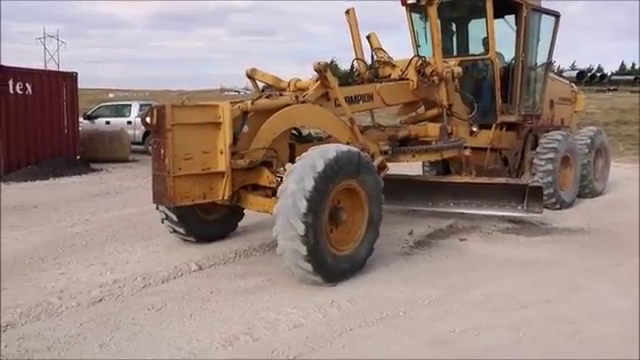

In [ ]:
I

(640, 360)
(640, 360)
[0 1 2 3]


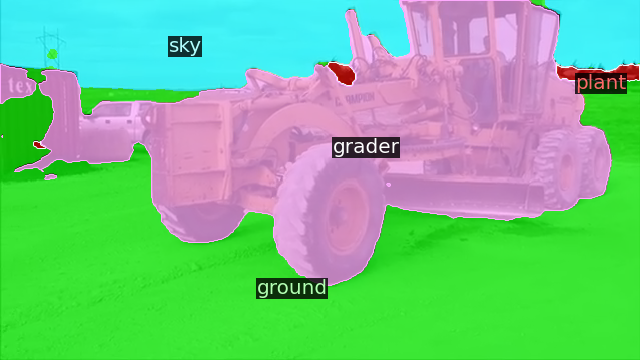

In [ ]:
import torch

I = Image.open('/content/grader_____img_258.png')
segments_info = [{"id": 0, "isthing": False, "category_id": 8, "area": 35768}, 
                 {"id": 1, "isthing": False, "category_id": 6, "area": 1629}, 
                 {"id": 2, "isthing": True, "category_id": 17, "area": 88693}, 
                 {"id": 3, "isthing": False, "category_id": 5, "area": 104310}]
print(I.size)

panoptic_seg = Image.open('/content/drive/MyDrive/Dataset/Checkpoints/9/panoptic_eval/000000000020.png')
final_w, final_h = panoptic_seg.size
print(panoptic_seg.size)

panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

print(np.unique(panoptic_seg_id))

# # Finally we color each mask individually
# panoptic_seg[:, :, :] = 0
# for id in range(panoptic_seg_id.max() + 1):
#     color = np.asarray(next(palette)) * 255
#     panoptic_seg[panoptic_seg_id == id] = color

# Finally we visualize the prediction
v = Visualizer(np.array(I.copy().resize((final_w, final_h)))[:, :, ::-1], custom_meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
cv2_imshow(v.get_image())

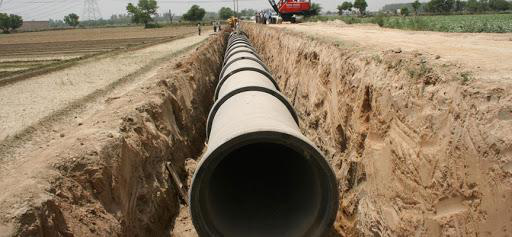

In [ ]:
I

(512, 237)
(512, 237)
[0 1 2 3]


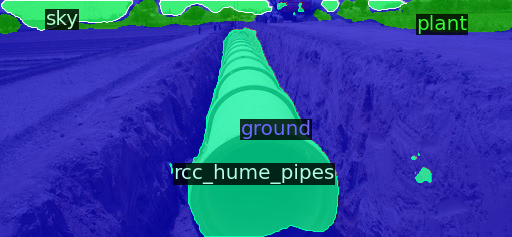

In [ ]:
import torch

I = Image.open('/content/rcc_hume_pipes_____image75.jpg')
segments_info = deepcopy(json_data['annotations'][29]['segments_info'])
for seg in segments_info:
    if seg['isthing'] is False:
        seg['category_id'] = stuffid2cont[seg['category_id']]

print(I.size)

panoptic_seg = Image.open('/content/drive/MyDrive/Dataset/Checkpoints/9/panoptic_eval/000000000030.png')
final_w, final_h = panoptic_seg.size
print(panoptic_seg.size)

panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

print(np.unique(panoptic_seg_id))

# # Finally we color each mask individually
# panoptic_seg[:, :, :] = 0
# for id in range(panoptic_seg_id.max() + 1):
#     color = np.asarray(next(palette)) * 255
#     panoptic_seg[panoptic_seg_id == id] = color

# Finally we visualize the prediction
v = Visualizer(np.array(I.copy().resize((final_w, final_h)))[:, :, ::-1], custom_meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0,)
cv2_imshow(v.get_image())

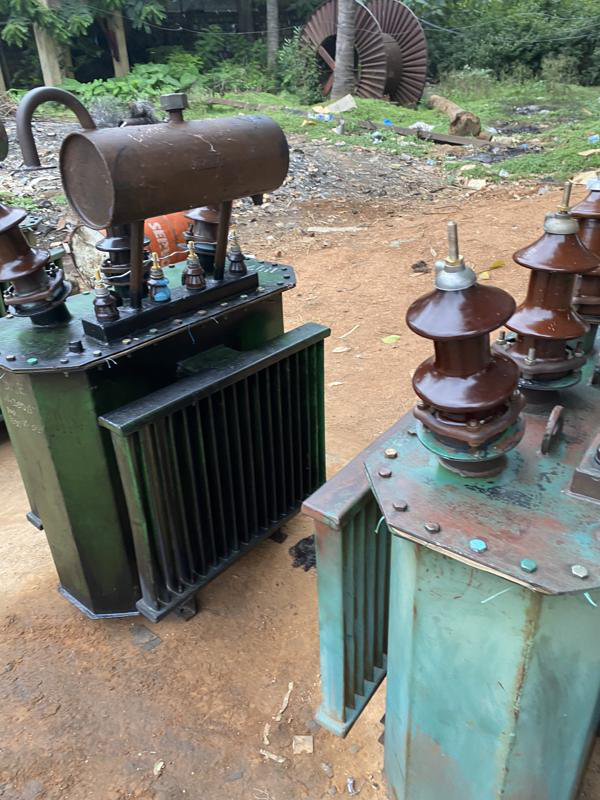

In [ ]:
I

(600, 800)
(600, 800)
[0 1 2]


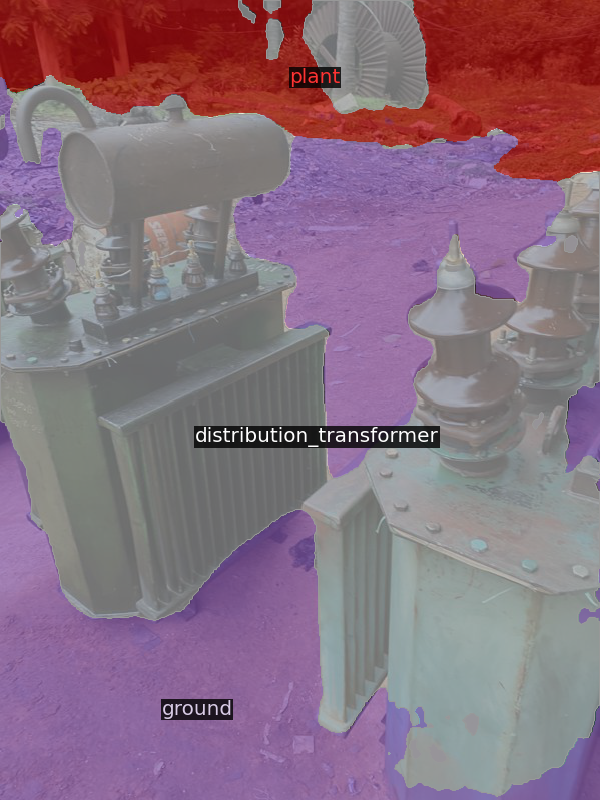

In [ ]:
import torch

I = Image.open('/content/distribution_transformer_____Image_116.jpeg')
segments_info = deepcopy(json_data['annotations'][93]['segments_info'])
for seg in segments_info:
    if seg['isthing'] is False:
        seg['category_id'] = stuffid2cont[seg['category_id']]

print(I.size)

panoptic_seg = Image.open('/content/drive/MyDrive/Dataset/Checkpoints/9/panoptic_eval/000000000094.png')
final_w, final_h = panoptic_seg.size
print(panoptic_seg.size)

panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

print(np.unique(panoptic_seg_id))

# # Finally we color each mask individually
# panoptic_seg[:, :, :] = 0
# for id in range(panoptic_seg_id.max() + 1):
#     color = np.asarray(next(palette)) * 255
#     panoptic_seg[panoptic_seg_id == id] = color

# Finally we visualize the prediction
v = Visualizer(np.array(I.copy().resize((final_w, final_h)))[:, :, ::-1], custom_meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0,)
cv2_imshow(v.get_image())

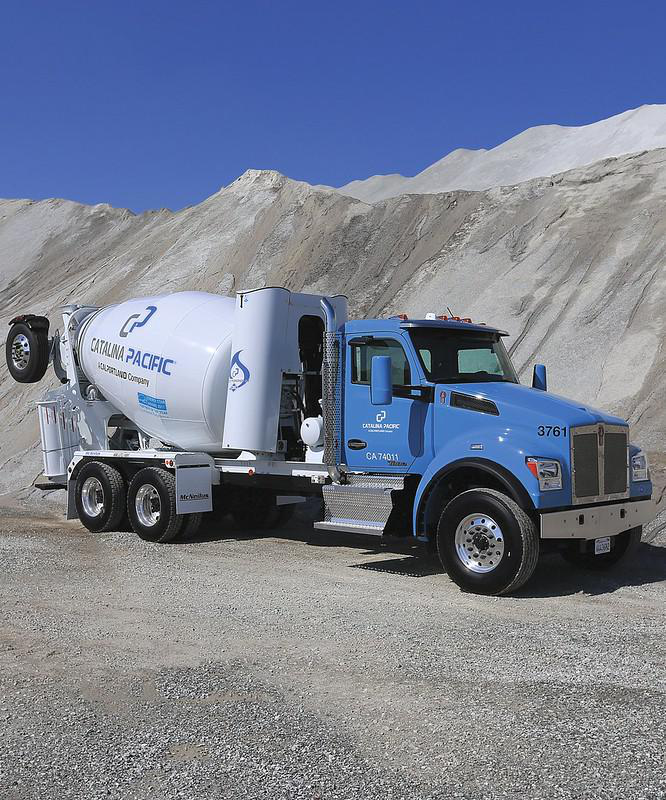

In [ ]:
I

(666, 800)
(666, 800)
[0 1 2 3]


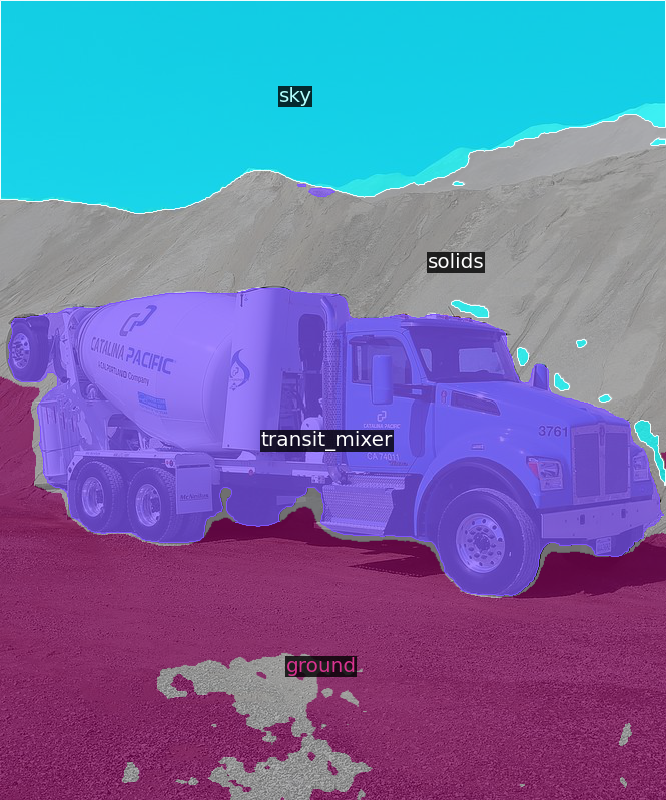

In [ ]:
import torch

I = Image.open('/content/transit_mixer_____img_019.jpg')
segments_info = deepcopy(json_data['annotations'][97]['segments_info'])
for seg in segments_info:
    if seg['isthing'] is False:
        seg['category_id'] = stuffid2cont[seg['category_id']]

print(I.size)

panoptic_seg = Image.open('/content/drive/MyDrive/Dataset/Checkpoints/9/panoptic_eval/000000000098.png')
final_w, final_h = panoptic_seg.size
print(panoptic_seg.size)

panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

print(np.unique(panoptic_seg_id))

# # Finally we color each mask individually
# panoptic_seg[:, :, :] = 0
# for id in range(panoptic_seg_id.max() + 1):
#     color = np.asarray(next(palette)) * 255
#     panoptic_seg[panoptic_seg_id == id] = color

# Finally we visualize the prediction
v = Visualizer(np.array(I.copy().resize((final_w, final_h)))[:, :, ::-1], custom_meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0,)
cv2_imshow(v.get_image())

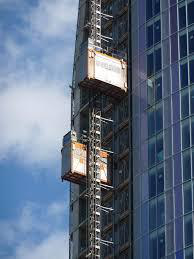

In [ ]:
I

(194, 259)
(194, 259)
[0 1 2]


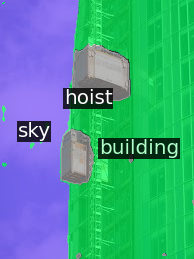

In [ ]:
import torch

I = Image.open('/content/hoist_____img_214.jpg')
segments_info = deepcopy(json_data['annotations'][210]['segments_info'])
for seg in segments_info:
    if seg['isthing'] is False:
        seg['category_id'] = stuffid2cont[seg['category_id']]

print(I.size)

panoptic_seg = Image.open('/content/drive/MyDrive/Dataset/Checkpoints/9/panoptic_eval/000000000212.png')
final_w, final_h = panoptic_seg.size
print(panoptic_seg.size)

panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

print(np.unique(panoptic_seg_id))

# # Finally we color each mask individually
# panoptic_seg[:, :, :] = 0
# for id in range(panoptic_seg_id.max() + 1):
#     color = np.asarray(next(palette)) * 255
#     panoptic_seg[panoptic_seg_id == id] = color

# Finally we visualize the prediction
v = Visualizer(np.array(I.copy().resize((final_w, final_h)))[:, :, ::-1], custom_meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0,)
cv2_imshow(v.get_image())

In [ ]:
!cp -r /content/output/Final_segments /content/drive/MyDrive/Dataset/Checkpoints

# After Epoch 20

In [24]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind()
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h,
                          img_w, img_h
                          ], dtype=torch.float32)
    return b

In [ ]:
# Plot all the remaining masks
ncols = 2
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))


only_maps = []
segments_info = []
mask_log_list = []
existing_set = set()
id_ = 0

for i, (attn_map,logit,bbox) in enumerate(zip(out["pred_masks"][keep], out["pred_logits"][keep], out["pred_boxes"][keep])):
    segments = {}
    logit = logit.softmax(-1).argmax().item()
    if logit == 64:
        continue
    axs.ravel()[id_].imshow(attn_map.detach().numpy())
    axs.ravel()[id_].axis('off')
    axs.ravel()[id_].set_xlabel('Test')
    segments['area'] = 1000

    if logit > 47:
        class_name = stuff_id2name[logit]
        segments['category_id'] = stuffid2cont[logit]
        segments['isthing'] = False
    else:
        class_name = thing_id2name[logit]
        segments['category_id'] = logit
        segments['isthing'] = True
        # attn_map *= 0.5

    if class_name in existing_set:
        continue
    existing_set.add(class_name)
    bbox = rescale_bboxes(bbox, (final_w, final_h))
    mask_log_list.append( ( attn_map, logit, class_name, bbox) )
    segments['id'] = id_
    id_ += 1
    segments_info.append(segments)
    only_maps.append(attn_map)



black_img = torch.zeros_like(only_maps[0])
only_maps.append(black_img)

combined_attn = torch.stack(only_maps)
# print(combined_attn.shape)
combined_attn = torch.argmax(combined_attn, dim=0).numpy()
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
combined_attn = cv2.resize(combined_attn, (final_w, final_h), interpolation= cv2.INTER_NEAREST)

# for idx, (_,_,_,bbox) in enumerate(mask_log_list):
#     temp_mask = np.zeros_like(combined_attn)
#     temp_mask[...] = 255
#     x1,y1,x2,y2 = map(int, bbox.numpy())
#     temp_mask[y1:y2, x1:x2] = combined_attn[y1:y2, x1:x2]
#     combined_attn = np.where(combined_attn==idx, temp_mask, combined_attn)

fig.tight_layout()

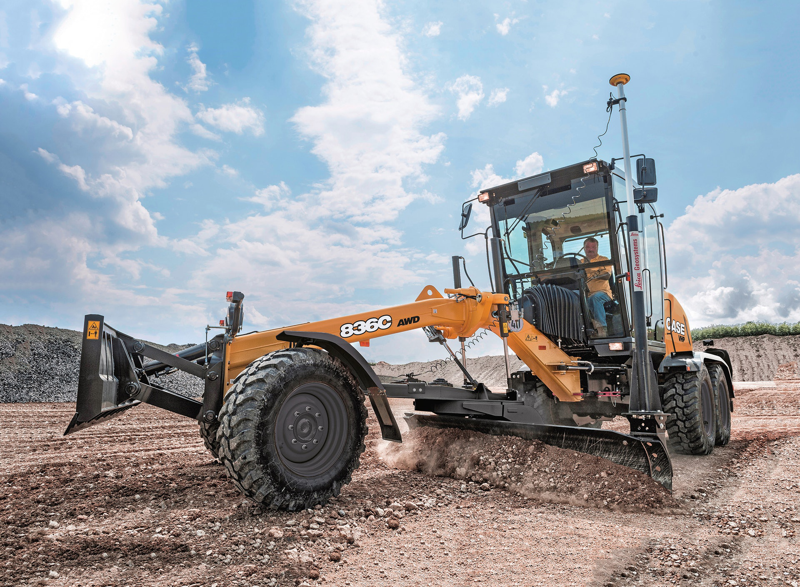

In [25]:
image_name = 'grader_____img_010.png' ##dump_truck___tipper_truck_____DT79.jpg #grader_____img_051.png #distribution_transformer_____Image_62.jpeg #rmc_batching_plant_____img_043.jpg
I = Image.open(f'/content/DETR/detr/datasets/images/{image_name}') 
I

In [ ]:
I.resize((final_w, final_h))

In [27]:
thresh = 0.8
model, postprocessor = torch.hub.load('DETR/detr', 'detr_resnet50_panoptic', source='local', pretrained='/content/output/checkpoint.pth', return_postprocessor=True, num_classes=64, threshold=thresh)
model.to('cuda')
model.eval()
print('Loaded!')

Loaded!


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/fun

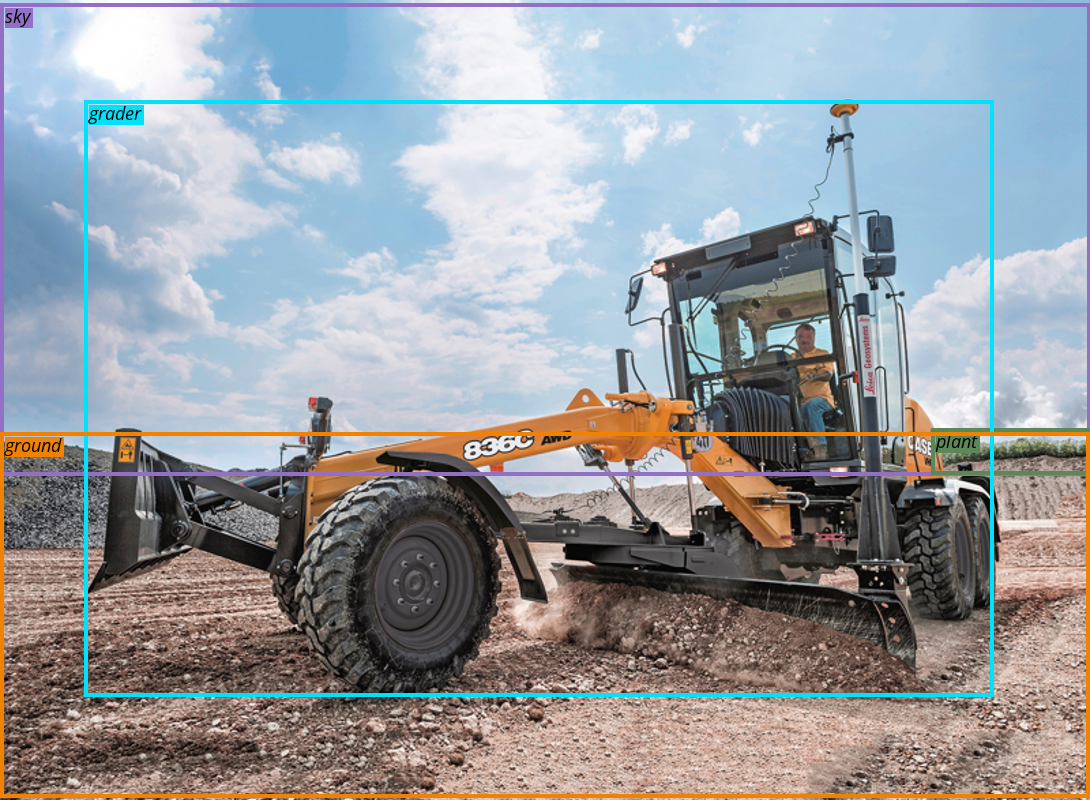

In [28]:
import io

with torch.no_grad():
    img = transform(I).unsqueeze(0).to('cuda')
    out = model(img)

out["pred_logits"] = out["pred_logits"].to('cpu')
out["pred_boxes"] = out["pred_boxes"].to('cpu')
out["pred_masks"] = out["pred_masks"].to('cpu')

result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size

# compute the scores, excluding the "no-object" class (the last one)
scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
# threshold the confidence
keep = scores > thresh


from PIL import ImageDraw, ImageFont
I_copy = I.copy().resize((final_w, final_h))
img_draw = ImageDraw.Draw(I_copy)
font = ImageFont.truetype("/content/drive/MyDrive/OpenSans-Italic-VariableFont_wdth,wght.ttf", 18)
for logit, i in zip(out['pred_logits'][keep], out['pred_boxes'][keep]):
    logit = logit.softmax(-1).argmax().item()
    a1,b1,c1,d1 = rescale_bboxes(i, (final_w, final_h)).to(torch.int)
    a1,b1,c1,d1 = a1.item(),b1.item(),c1.item(),d1.item()
    img_draw.rectangle((a1,b1,c1,d1), width=4, outline=tuple(CATEGORY_COLOR[logit]))
    class_name = ALL_CLASSES[logit]
    font_w, font_h = font.getsize(class_name)
    img_draw.rectangle((a1+5, b1+5, a1+font_w+5, b1+font_h), fill=tuple(CATEGORY_COLOR[logit]))
    img_draw.text((a1+5, b1), ALL_CLASSES[logit], fill='black', font=font)
I_copy

(1066, 800)


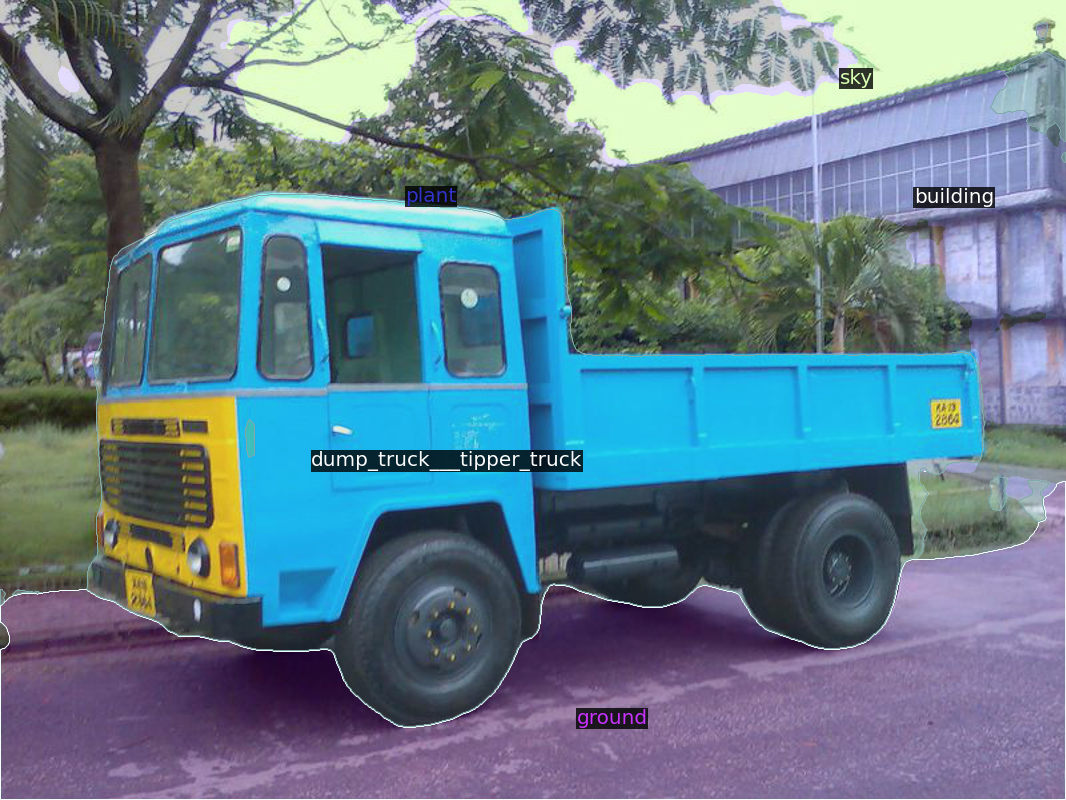

In [ ]:
# We extract the segments info and the panoptic result from DETR's prediction
import io

segments_info = deepcopy(result["segments_info"])

# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
print(panoptic_seg.size)
final_w, final_h = panoptic_seg.size

# We convert the png into an segment id map
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))

# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
existing_set = set()
new_segment = []
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    if c in existing_set:
        continue
    existing_set.add(c)
    seg = segments_info[i]
    seg["category_id"] = c if c<=47 else stuffid2cont[c]
    seg["isthing"] = True if c<=47 else False
    new_segment.append(seg)


# Finally we visualize the prediction
v = Visualizer(np.array(I.copy().resize((final_w, final_h)))[:, :, ::-1], custom_meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, new_segment, area_threshold=0, alpha=0.3)
cv2_imshow(v.get_image())

In [ ]:
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
v = Visualizer(np.array(I.copy().resize((final_w, final_h)))[:, :, ::-1], custom_meta, scale=1.0)
v._default_font_size = 20
v_out = v.draw_panoptic_seg_predictions(torch.from_numpy(combined_attn), segments_info, area_threshold=0,alpha=0.5)
cv2_imshow(v_out.get_image())

# Inference on ALL Images

In [ ]:
# from tqdm import tqdm
# for image_path in tqdm(glob.glob('/content/DETR/detr/datasets/images/*')):

#     I = Image.open(image_path) 
#     og_w, og_h = I.size

#     image_name = Path(image_path).with_suffix('.png').name    

#     with torch.no_grad():
#         img = transform(I).unsqueeze(0).to('cuda')
#         out_ = model(img)
#         out = {}
#         for k,v in out_.items():
#             out[k] = v.to('cpu')
#         del out_

#     # compute the scores, excluding the "no-object" class (the last one)
#     scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
#     # threshold the confidence
#     keep = scores > 0.7

#     only_maps = []
#     segments_info = []
#     mask_log_list = []
#     existing_set = set()
#     id_ = 0
#     for i, (attn_map,logit,bbox) in enumerate(zip(out["pred_masks"][keep], out["pred_logits"][keep], out["pred_boxes"][keep])):
#         segments = {}
#         segments['area'] = 1000
#         logit = logit.softmax(-1).argmax().item()

#         if logit > 47:
#             class_name = stuff_id2name[logit]
#             segments['category_id'] = stuffid2cont[logit]
#             segments['isthing'] = False
#         else:
#             class_name = thing_id2name[logit]
#             segments['category_id'] = logit
#             segments['isthing'] = True

#         if class_name in existing_set:
#             continue
#         existing_set.add(class_name)
#         bbox = rescale_bboxes(bbox, (og_w, og_h))
#         mask_log_list.append( ( attn_map, logit, class_name, bbox) )
#         segments['id'] = id_
#         id_ += 1
#         segments_info.append(segments)
#         only_maps.append(attn_map)

#     if len(only_maps) == 0: continue
#     if len(only_maps) == 1:
#         black_img = torch.zeros_like(only_maps[0])
#         only_maps.append(black_img)

#     combined_attn = torch.stack(only_maps)
#     combined_attn = torch.argmax(combined_attn, dim=0).numpy()
#     combined_attn = cv2.resize(combined_attn, (og_w, og_h), interpolation= cv2.INTER_NEAREST)

#     for idx, (_,_,_,bbox) in enumerate(mask_log_list):
#         temp_mask = np.zeros_like(combined_attn)
#         temp_mask[...] = 255
#         x1,y1,x2,y2 = map(int, bbox.numpy())
#         temp_mask[y1:y2, x1:x2] = combined_attn[y1:y2, x1:x2]
#         combined_attn = np.where(combined_attn==idx, temp_mask, combined_attn)


#     v = Visualizer(np.array(I), custom_meta, scale=1.0)
#     v._default_font_size = 20
#     v_out = v.draw_panoptic_seg_predictions(torch.from_numpy(combined_attn), segments_info, area_threshold=0,alpha=0.25)
#     v_out.save(f'/content/inference_images/{image_name}')

  0%|          | 0/11879 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
!cp -r /content/inference_images /content/drive/MyDrive/Dataset/Checkpoints/PanopticSegmentations